### パッケージのインポート

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.optim import SGD
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

In [2]:
seed = 316

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

### データフレームの作成

In [3]:
# メインデータフレームの作成
main_df = pd.read_csv("../data/tsunami/NOWPHAS_Tsunami_data/cmp_csv/cut_2011TET801G.csv", index_col=0)
main_df = main_df.drop(["index", "deviation", "datetime"], axis=1)

# 過去の水位データの連結
main_df_times = [f"observed_{5*i}s" for i in range(1, 13)]
for i in range(len(main_df_times)):
    main_df[main_df_times[i]] = main_df["observed"].shift(i+1)
    main_df[main_df_times[i]] = main_df["observed"] - main_df[main_df_times[i]]

# 801Gより先に津波が到達する地点の水位データを結合
cmp_filenames = ["2011TET318T.csv", "2011TET317T.csv",
                 "2011TET315T.csv", "2011TET319T.csv",
                 "2011TET802G.csv", "2011TET804G.csv",
                 "2011TET803G.csv", "2011TET806G.csv"]

pre_list = []
pre_columns = []

for filename in cmp_filenames:
    pre_df = pd.read_csv("../data/tsunami/NOWPHAS_Tsunami_data/cmp_csv/cut_"+filename, index_col=0)
    pre_list.append(pre_df["observed"])
    pre_columns.append(f"observed+{filename[7:11]}")

for i in range(len(pre_columns)):
    main_df[pre_columns[i]] = pre_list[i]

# 欠損値を含むデータの削除
main_df_full = main_df.copy().dropna()
main_df_full = main_df_full.reset_index().drop("index", axis=1)

for col in main_df_times:
    main_df_full[col] = main_df_full["observed"] - main_df_full[col]

### ネットワーク

#### 前処理

In [4]:
def to_torch(X: np.ndarray, y: np.ndarray) -> tuple[torch.Tensor, torch.Tensor]:
    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y).float()
    return X, y


def prepare_nn(main_df, test_size_1, test_size_2):
    std_x = StandardScaler()
    std_y = StandardScaler()
    X = std_x.fit_transform(main_df.drop("observed", axis=1))
    y = std_y.fit_transform(main_df[["observed"]])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_1, shuffle=False)
    X_valid, X_eval, y_valid, y_eval = train_test_split(X_test, y_test, test_size=test_size_2, shuffle=False)
    train_df = pd.DataFrame(np.hstack((y_train, X_train)), columns=main_df.columns)
    valid_df = pd.DataFrame(np.hstack((y_valid, X_valid)), columns=main_df.columns)
    eval_df = pd.DataFrame(np.hstack((y_eval, X_eval)), columns=main_df.columns)

    # Tensor型に変換
    X_train, y_train = to_torch(X_train, y_train)
    X_valid, y_valid = to_torch(X_valid, y_valid)
    X_eval, y_eval = to_torch(X_eval, y_eval)

    return std_x, std_y, X_train, y_train, X_valid, y_valid, X_eval, y_eval, train_df, valid_df, eval_df

In [5]:
std_x, std_y, X_train, y_train, X_valid, y_valid, X_eval, y_eval, train_df, valid_df, eval_df = prepare_nn(main_df_full, 0.3, 0.5)

train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)

# DataLoader型に変換
batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)

#### モデルの構築

In [6]:
# モデルの定義
class NeuralNetwork(nn.Module):
    def __init__(
        self, input_dim, output_dim,
        first_dim, second_dim
    ):
        super().__init__()
        self.flatten = nn.Flatten()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, first_dim),
            nn.LeakyReLU(),
            nn.Linear(first_dim, second_dim),
            nn.LeakyReLU(),
            nn.Linear(second_dim, output_dim)
        )

    def forward(self, x):
        x = self.flatten(x)
        outputs = self.linear_relu_stack(x)
        return outputs

In [7]:
# デバイスの選択
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [8]:
# インスタンスの作成
model = NeuralNetwork(21, 1, 32, 2).to(device)

#### 学習用の最適化器と損失関数の設定

In [9]:
# 最適化器にはSGD(確率的勾配降下法)を,損失関数には平均二乗誤差を用いる
optimizer = SGD(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

#### モデルの学習

In [10]:
def model_train(epochs, train_dataloader, valid_dataloader, model, optimizer, criterion, batch_size):
    dataloader_dict = {
        "Train": train_dataloader,
        "Valid": valid_dataloader
    }

    # 学習ロスのリスト
    training_data = []
    with tqdm(range(epochs)) as pbar_epoch:
        for epoch in pbar_epoch:
            pbar_epoch.set_description(f"epoch : {epoch + 1}")
            metas = []

            # 学習中orテスト中で処理を分岐
            for phase in ["Train", "Valid"]:
                if phase == "Train":
                    model.train()
                else:
                    model.eval()

                epoch_loss = 0.0

                for inputs, label in dataloader_dict[phase]:
                    inputs = inputs.to(device)
                    label = label.to(device)
                    optimizer.zero_grad()

                    # 学習中のみ、勾配の計算を行う
                    with torch.set_grad_enabled(phase == "Train"):
                        outputs = model(inputs)
                        loss = criterion(outputs, label) ** 0.5
                        
                        # 逆伝播を行う
                        if phase == "Train":
                            loss.backward()
                            optimizer.step()

                        epoch_loss += loss.item() * inputs.size(0)

                # エポックのロスを計算
                epoch_loss = epoch_loss / (len(dataloader_dict[phase].dataset) * batch_size)

                # エポックごとのロスを連結
                meta = {"Loss": epoch_loss}
                metas.append(meta)
           
            training_data.append(dict(zip(["Train", "Valid"], metas)))

    return model, training_data

In [11]:
# 学習
model, training_data = model_train(
    epochs=100,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    batch_size=batch_size
)

print(list(model.parameters()))

epoch : 100: 100%|██████████| 100/100 [00:01<00:00, 70.13it/s]

[Parameter containing:
tensor([[ 4.9356e-02, -1.5411e-01,  1.8103e-01, -7.3494e-02,  2.2179e-01,
          1.1269e-01, -9.3858e-02,  2.4647e-02,  3.6856e-02, -1.2455e-01,
          1.0175e-03,  2.5206e-02,  9.1538e-02, -1.1003e-02, -7.2619e-02,
         -2.0312e-01,  1.1515e-01, -8.3964e-02,  9.7962e-02, -8.3511e-02,
          9.6697e-02],
        [ 2.6666e-01,  1.5440e-01,  8.8070e-02,  1.1327e-01,  1.2903e-01,
          2.0954e-01, -1.8320e-01,  9.5362e-03, -2.5734e-02, -7.2389e-02,
          3.2374e-02, -1.0262e-01,  1.5476e-02, -7.0722e-03,  1.3486e-01,
          1.0782e-01, -3.5863e-02,  1.3616e-01, -6.8652e-02,  1.5624e-01,
         -9.6136e-02],
        [-1.0339e-01, -5.2109e-01, -2.4643e-01, -4.3918e-02, -3.0922e-01,
          9.9547e-02, -1.4335e-01, -4.6157e-02,  5.6699e-02,  1.1414e-01,
         -2.5291e-02,  8.3185e-02,  1.2057e-01,  5.3430e-02,  1.3203e-01,
          2.5471e-01, -9.7901e-03,  1.0626e-01,  1.4445e-04, -1.0798e-01,
          3.0010e-01],
        [-8.4162e-02

#### 学習結果の確認

In [12]:
def plot_data(training_data, mode):
    train_y = [training_data[i]["Train"][mode] for i in range(len(training_data))]
    valid_y = [training_data[i]["Valid"][mode] for i in range(len(training_data))]

    x = [i + 1 for i in range(len(train_y))]

    plt.figure(figsize=(18, 12))
    plt.title(f"{mode} comparison", size=15, color="red")
    plt.grid()

    plt.plot(x, train_y, label="Train")
    plt.plot(x, valid_y, label="Valid")
    plt.xlabel("Epoch")
    plt.ylabel(mode)

    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left", borderaxespad=0.)
    plt.show()

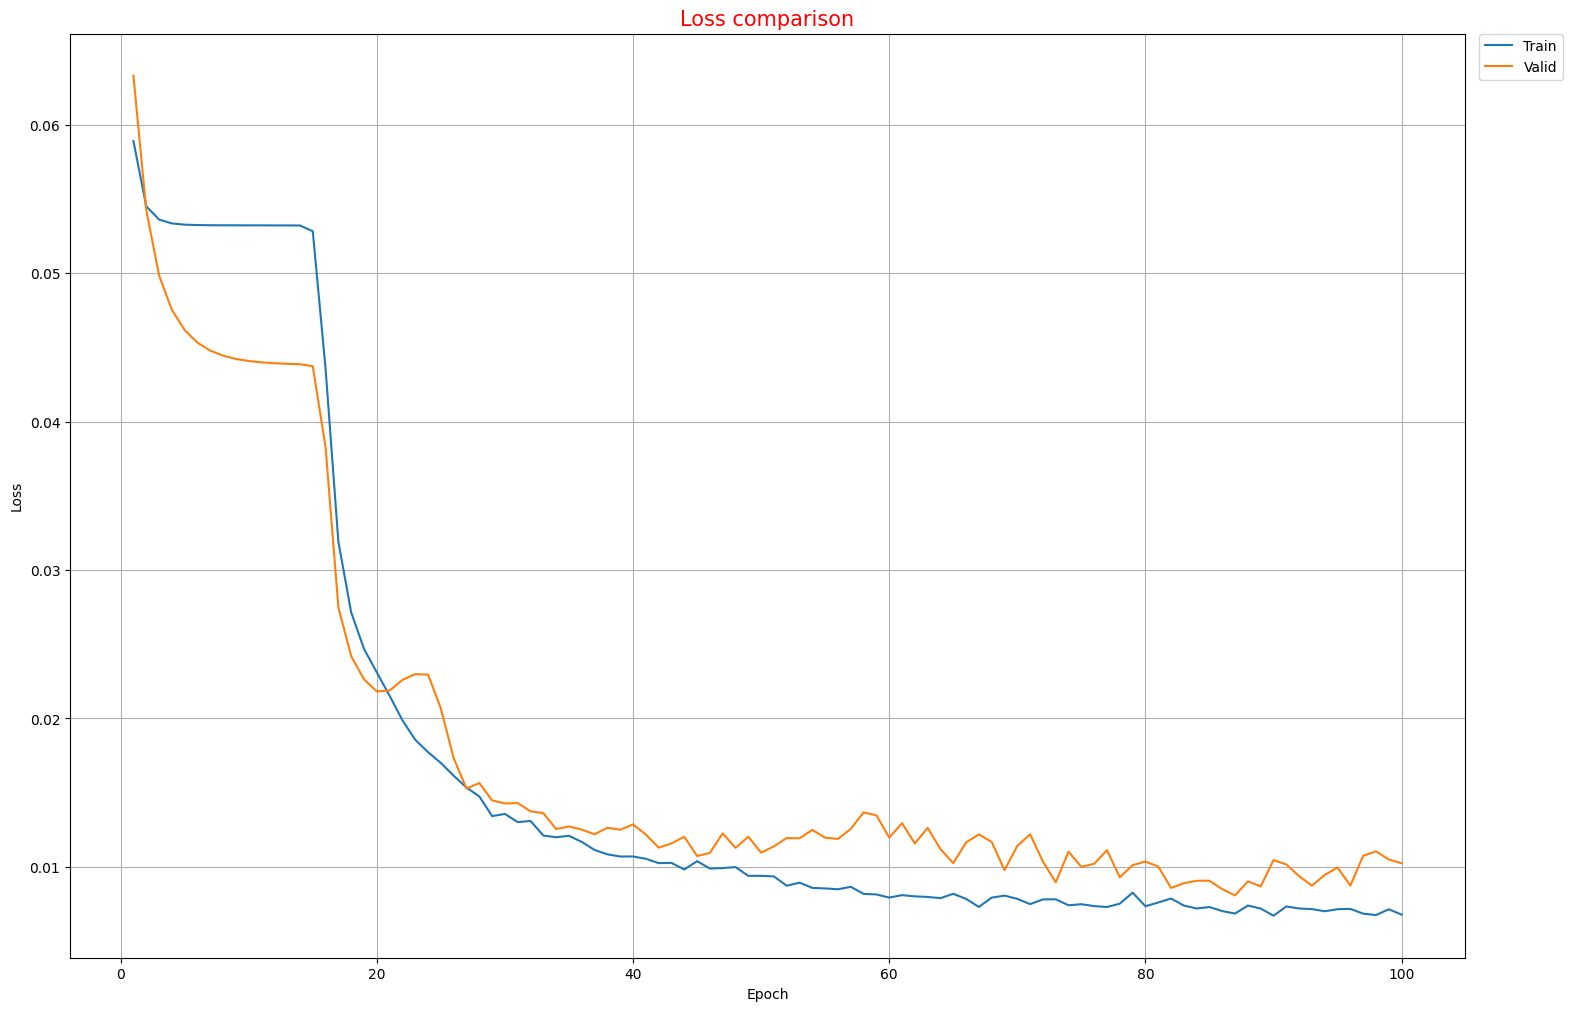

In [13]:
plot_data(training_data, "Loss")

In [14]:
# 真の値と予測値との差の可視化
def torch_compare_preds(y_eval, y_pred):
    y_pred = y_pred.detach().numpy().copy()
    y_pred = std_y.inverse_transform(pd.DataFrame(y_pred))

    plt.figure(figsize=(10, 5))
    plt.grid()

    plt.plot(y_eval, label='correct')
    plt.plot(y_pred, label='prediction')

    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    plt.show()


# 結果の出力
def result_print(std, df, X):
    y_pred = model(X).detach().numpy()
    y_pred = std.inverse_transform(y_pred)
    y = std.inverse_transform(df["observed"].to_frame())

    print("MSE : ", np.mean((y_pred - y) ** 2))
    print("r^2 train data : ", r2_score(y_pred, y))

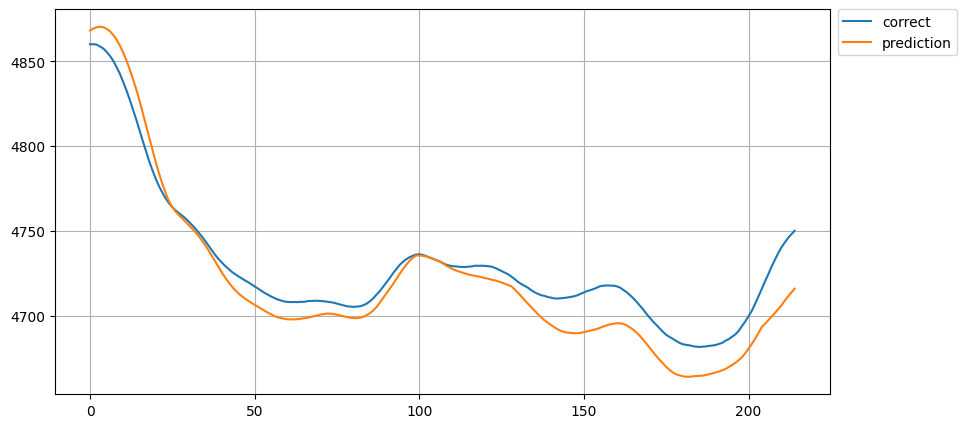

In [15]:
# y_evalとy_predの差を可視化
y_pred = model(X_eval)
y_eval_copy = std_y.inverse_transform(eval_df["observed"].to_frame())

torch_compare_preds(y_eval_copy, y_pred)

In [16]:
# 定量的評価
print("train : ")
result_print(std_y, train_df, X_train)

print("valid : ")
result_print(std_y, valid_df, X_valid)

print("eval : ")
result_print(std_y, eval_df, X_eval)

train : 
MSE :  597.3363185620914
r^2 train data :  0.9848069492621718
valid : 
MSE :  1537.5720888464348
r^2 train data :  0.4637983964114136
eval : 
MSE :  213.44024338425353
r^2 train data :  0.9085060094176185
